### Actual code to find loop rmsds between trajectories
Also see traj_analysis.ipynb (copied from here)

In [ ]:
'''
Calculate the RMSD of the loops between trajectories. Supported loops are h/l1-3, heavy,light, all.
NOTE THAT SELECTIONS HAVE TO BE EQUIVALENT.
'''

import sys
import matplotlib
import numpy as np
import MDAnalysis as mda
import pyrosetta as py
from MDAnalysis.analysis import rms
from pyrosetta.rosetta.protocols import antibody
from rosetta.protocols.antibody.residue_selector import CDRResidueSelector
import matplotlib.pyplot as plt
import seaborn as sns
cmap = matplotlib.cm.get_cmap("jet", 6)
py.init('-out:level 0')

ref_top = '340K_pierce_simulations/9/mdframe.pdb'
ref_traj = '340K_pierce_simulations/9/md_corrected.xtc'
mobile_top = 'pierce_simulations/9/mdframe.pdb'
mobile_traj = 'pierce_simulations/9/md_corrected.xtc'
name = '1'
index_ref = 340
index_mob = 310
rmsd_val = 1
renumbered_pdb = 'pierce_simulations/9/fv_chothia.pdb'
cdr = 'h3'

pose = py.pose_from_pdb(renumbered_pdb)
ab_info = antibody.AntibodyInfo(pose, antibody.Chothia_Scheme, antibody.North)

if cdr == 'all':
    vec = ab_info.get_all_cdrs()
elif cdr == 'heavy':
    vec = py.rosetta.utility.vector1_bool(6)
    vec[antibody.h1] = True
    vec[antibody.h2] = True
    vec[antibody.h3] = True

elif cdr == 'light':
    vec = py.rosetta.utility.vector1_bool(6)
    vec[antibody.l1] = True
    vec[antibody.l2] = True
    vec[antibody.l3] = True

else:
    vec = py.rosetta.utility.vector1_bool(6)
    vec[getattr(antibody,cdr)] = True

cdr_sel = py.rosetta.protocols.antibody.residue_selector.CDRResidueSelector(ab_info, vec)
where = np.where(cdr_sel.apply(pose))

u = mda.Universe(ref_top,ref_traj)
v = mda.Universe(mobile_top,mobile_traj)

u.transfer_to_memory(step=10,verbose=True)
v.transfer_to_memory(step=100,verbose=True)

if (cdr == 'h1') or (cdr=='h2') or (cdr=='h3') or (cdr=='heavy'):
    x = 0
    framework = np.concatenate((u.segments.resindices[0][5:11+1], u.segments.resindices[0][38:45+1],u.segments.resindices[0][80:90+1],u.segments.resindices[0][105:len(pose.chain_sequence(1))]))
    loop = u.segments.resindices[0][where]
elif (cdr == 'l1') or (cdr=='l2') or (cdr=='l3') or (cdr=='light'):
    x = 1
    framework = np.concatenate((u.segments.resindices[1][6:19+1], u.segments.resindices[1][37:43+1],u.segments.resindices[1][75:84+1],u.segments.resindices[1][100:len(pose.chain_sequence(2))]))
    loop = u.segments.resindices[1][where[0]-len(pose.chain_sequence(1))]
elif cdr == 'all':
    framework1 = np.concatenate((u.segments.resindices[0][5:11+1], u.segments.resindices[0][38:45+1],u.segments.resindices[0][80:90+1],u.segments.resindices[0][105:len(pose.chain_sequence(1))]))
    framework2 = np.concatenate((u.segments.resindices[1][6:19+1], u.segments.resindices[1][37:43+1],u.segments.resindices[1][75:84+1],u.segments.resindices[1][100:len(pose.chain_sequence(2))]))
    framework = np.concatenate((framework1,framework2))

resids = ''
for i in framework:
    resids += 'resindex ' + str(i) + ' or '
framework_selection = 'not name O and (backbone and (' + resids[:-4] +'))'

resids = ''
for i in loop:
    resids += 'resindex ' + str(i) + ' or '
loop_selection = 'not name O and (backbone and (' + resids[:-4] +'))'
    
frmsd = np.zeros([len(u.trajectory), len(v.trajectory)]) #framework rmsd
lrmsd = np.zeros([len(u.trajectory), len(v.trajectory)]) # loop rmsd

for i in range(0,len(u.trajectory)):
    r = rms.RMSD(v, u, select=framework_selection, ref_frame=i, groupselections=[loop_selection]).run()
    frmsd[i,:] = r.rmsd[:,2]
    lrmsd[i,:] = r.rmsd[:,3]

match = np.where((lrmsd<float(rmsd_val)).any(axis=1))[0].shape[0]/len(v.trajectory)
print(name,index_ref,index_mob,cdr,rmsd_val,str(match)[:4],sep='\t')

plt.figure(figsize=(12,8))
sns.heatmap(lrmsd, cmap = cmap, vmin=0,vmax=6)
plt.xlabel('Mobile-'+str(index_mob))
plt.ylabel('Reference-'+str(index_ref))
plt.title(str(name)+' Frame-wise RMSD  ($\AA$) '+str(cdr))
plt.savefig("{}_lrmsd_{}_{}_{}.png".format(name,index_ref,index_mob,cdr),dpi=300, facecolor='white',bbox_inches='tight')

plt.figure(figsize=(12,8))
sns.heatmap(frmsd, cmap = cmap, vmin=0,vmax=6)
plt.xlabel('Mobile-'+str(index_mob))
plt.ylabel('Reference-'+str(index_ref))
plt.title(str(name)+' Frame-wise RMSD  ($\AA$) '+str(cdr))
plt.savefig("{}_frmsd_{}_{}_{}.png".format(name,index_ref,index_mob,cdr),dpi=300, facecolor='white',bbox_inches='tight')

# Plot heatmaps

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

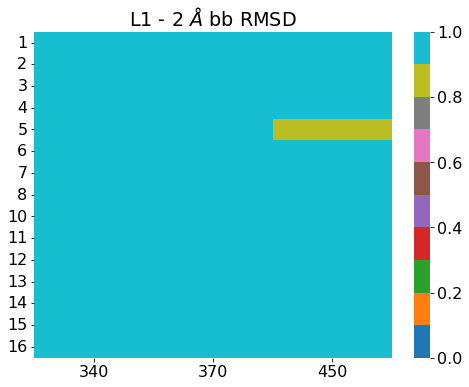

In [17]:
df = pd.read_table('l1_rmsd_similarity.out')
x = np.array(df['Match']).reshape(-1,3)
plt.figure(figsize=(8,6))
plt.rcParams['font.size']=16
sns.heatmap(x, vmin=0, vmax=1, cmap='tab10')
plt.xticks([0.5,1.5,2.5],['340','370','450']);
plt.yticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5,12.5,13.5,14.5],[str(i) for i in (1,2,3,4,5,6,7,8,10,11,12,13,14,15,16)], rotation='0');
plt.title('L1 - 2 $\AA$ bb RMSD')
plt.savefig('l1_rmsd_similarity.png',dpi=300,facecolor='white',bbox_inches='tight')